In [2]:
import numpy as np
from datetime import timedelta
import os, sys
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

notebook_path = os.getcwd()
print(notebook_path)
sys.path.append(os.path.join(notebook_path, '..', '..'))
from studies.flair import Flair

/Users/jan/git/nudgebg/egvinsulin/notebooks/understand-flair-dataset


# TDD

In [3]:
study_dataset_path = os.path.join(notebook_path, '..','..', 'data', 'raw', 'FLAIRPublicDataSet')
flair = Flair('Flair', study_dataset_path)
flair.load_data()
basal = flair.extract_basal_event_history()
bolus = flair.extract_bolus_event_history()

Now we calculate TDD, once based on the extracted basal and bolus information (calculated) and once on the reported TDD of the flair data (reported)

In [4]:
def calculate_tdd_basals(df):
    #add support points around midnight 
    supports = pd.date_range(df.datetime.min().date(), df.datetime.max().date()+pd.Timedelta(days=1), freq='D')
    missing_supports = supports[~supports.isin(df.datetime)]
    
    df = pd.concat([df, pd.DataFrame({'datetime': missing_supports})]).sort_values(by='datetime').reset_index(drop=True)
    df['basal_rate'] = df.basal_rate.ffill()
    #calculate TDDs, one day at a time
    TDDs  = []
    for (start,end) in zip(supports[:-1], supports[1:]):
        subFrame = df.loc[(df.datetime >= start) & (df.datetime <= end)]
        x = (subFrame.datetime.diff().dt.total_seconds()/3600).values[1:]
        y = subFrame['basal_rate'].values[:-1]
        tdd = np.nansum(x * y)
        TDDs.append(tdd)
    return pd.DataFrame({'date': supports[:-1].date, 'basal': TDDs})

from datetime import datetime
#test 1
test = pd.DataFrame({'datetime':[datetime(2019,1,1),datetime(2019,1,1,12)], 'basal_rate':[0,1.5]})
expected = pd.DataFrame({'date':[datetime(2019,1,1).date()], 'basal':[18.0]})
calculated_tdd = calculate_tdd_basals(test)
assert np.all(calculated_tdd['basal'].values == expected['basal'].values)

#test 2
test = pd.DataFrame({'datetime':[datetime(2019,1,1),datetime(2019,1,1,6),datetime(2019,1,1,12)], 'basal_rate':[0,1,2]})
expected = pd.DataFrame({'date':[datetime(2019,1,1).date()], 'basal':[30.0]})
calculated_tdd = calculate_tdd_basals(test)
assert np.all(calculated_tdd['basal'].values == expected['basal'].values)

#test 2
test = pd.DataFrame({'datetime':[datetime(2019,1,1,12)], 'basal_rate':[1]})
expected = pd.DataFrame({'date':[datetime(2019,1,1).date()], 'basal':[12.0]})
calculated_tdd = calculate_tdd_basals(test)
assert np.all(calculated_tdd['basal'].values == expected['basal'].values)


In [5]:
def extract_TDDs():
    tdds_flair = flair.df_pump.dropna(subset=['TDD'])[['PtID','DateTime','TDD']]
    tdds_flair['date'] = tdds_flair.DateTime.dt.date
    tdds_flair['datetime'] = tdds_flair.DateTime
    tdds_flair['PtID'] = tdds_flair.PtID.astype(str)
    tdds_flair = tdds_flair.rename(columns={'PtID':'patient_id','TDD':'tdd'})
    return tdds_flair

#get reported tdd 
tdd_reported = extract_TDDs().set_index(['patient_id','date'])
tdd_reported.name = 'reported'

#calculate basal tdd
tdd_basals = pd.DataFrame(basal.groupby(basal.patient_id).apply(calculate_tdd_basals))
tdd_basals = tdd_basals.reset_index().set_index(['patient_id','date']).drop(columns='level_1')

#calcualte bolus tdd
date = bolus.datetime.dt.date
date.name='date'
tdd_boluses = bolus.groupby(['patient_id',date]).agg({'bolus':'sum'})

#combine bolus and basal tdds
tdds_calculated = pd.merge(tdd_boluses ,tdd_basals, left_index=True, right_index=True, suffixes=['_bolus','_basal'])
tdds_calculated['tdd'] = tdds_calculated.bolus + tdds_calculated.basal

#combine dataframes and scatter plot
TDDs = pd.merge(tdds_calculated, tdd_reported, left_index=True, right_index=True, suffixes=['_calculated','_reported'])
display(TDDs)

bolus      basal  tdd_calculated            DateTime  \
patient_id date                                                               
1          2018-08-08  16.50  12.365611       28.865611 2018-08-08 23:59:59   
           2018-08-09  26.00  24.870528       50.870528 2018-08-09 23:59:59   
           2018-08-10  16.10  30.171111       46.271111 2018-08-10 23:59:59   
           2018-08-11  17.80  24.464417       42.264417 2018-08-11 23:59:59   
           2018-08-12  28.50  25.651111       54.151111 2018-08-12 23:59:59   
...                      ...        ...             ...                 ...   
99         2019-02-28  43.97  32.990611       76.960611 2019-02-28 23:59:59   
           2019-03-01  44.28  32.440722       76.720722 2019-03-01 23:59:59   
           2019-03-02  53.91  31.958111       85.868111 2019-03-02 23:59:59   
           2019-03-03  44.47  32.752222       77.222222 2019-03-03 23:59:59   
           2019-03-04  47.74  33.114667       80.854667 2019-03-04 23:59:59   

                       tdd_reported            datetime  
patient_id date                                          
1          2018-08-08        28.875 2018-08-08 23:59:59  
           2018-08-09        50.825 2018-08-09 23:59:59  
           2018-08-10        46.250 2018-08-10 23:59:59  
           2018-08-11        42.300 2018-08-11 23:59:59  
           2018-08-12        54.100 2018-08-12 23:59:59  
...                             ...                 ...  
99         2019-02-28        43.125 2019-02-28 23:59:59  
           2019-03-01        43.575 2019-03-01 23:59:59  
           2019-03-02        53.150 2019-03-02 23:59:59  
           2019-03-03        44.500 2019-03-03 23:59:59  
           2019-03-04        50.350 2019-03-04 23:59:59  

[25252 rows x 6 columns]

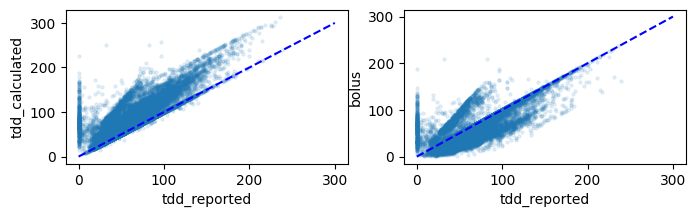

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
TDDs.plot.scatter(x='tdd_reported', y='tdd_calculated', marker='.', alpha=0.1, ax=axs[0])
axs[0].plot([0, 300], [0, 300], 'b--')
TDDs.plot.scatter(x='tdd_reported', y='bolus', marker='.', alpha=0.1, ax=axs[1])
axs[1].plot([0, 300], [0, 300], 'b--')

What we see is that the 
* calcualted tdds differ significantly from the extracted tdds 
* mostly calculated TDDs are too hight

There are multiple clusters:
 * Many instances where the extracted TDD is zero
 * Many instances where the calcualted is higher what appears to be a linear offset
* When looking at the boluses only, some TDDs are still too high.

Potential explanation for this: Potentiually the algorithm was switched and reported basal-rates were not actually delivered. Therefore, let's visualize reported basal rates by date.

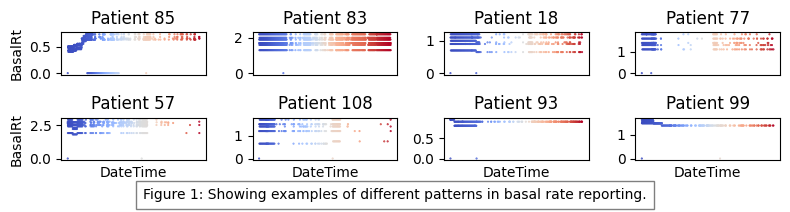

In [7]:
#patient_ids = [85,27,83,   18,77,104,  56,57,108,  53,93,99]
patient_ids = [85,83,   18,77,  57,108,  93,99]
#patient_ids = np.random.choice(np.unique(flair.df_pump.PtID.unique()),8, replace=False)
fig, axs = plt.subplots(2,4, figsize=(8, 2)); axs = axs.flatten()
for i, patient_id in enumerate(patient_ids):
    subFrame = flair.df_pump.loc[flair.df_pump.PtID == patient_id]#.dropna(subset=['BasalRt'])
    axs[i].scatter(subFrame['DateTime'], subFrame['BasalRt'], c=range(len(subFrame)), cmap='coolwarm', marker='.',s=1)
    axs[i].set_title(f'Patient {patient_id}')
    #hide x ticks
    axs[i].set_xticks([])
    if i>=4:
        axs[i].set_xlabel('DateTime')
    if i%4==0:
        axs[i].set_ylabel('BasalRt')

plt.tight_layout()
plt.figtext(0.5, -0.02, "Figure 1: Showing examples of different patterns in basal rate reporting.", ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
plt.show()


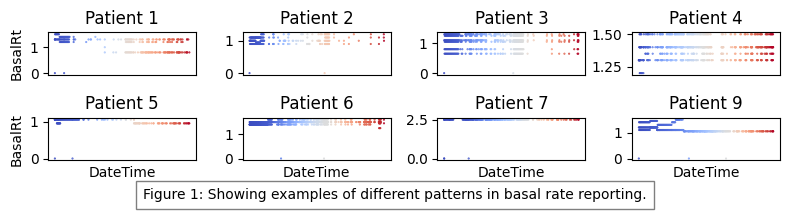

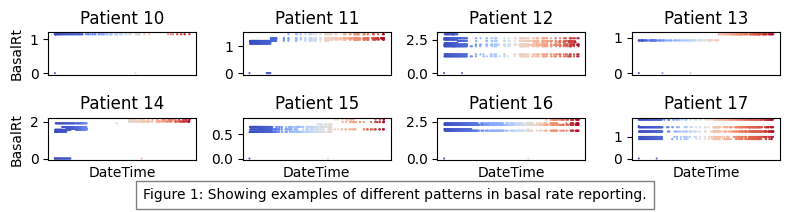

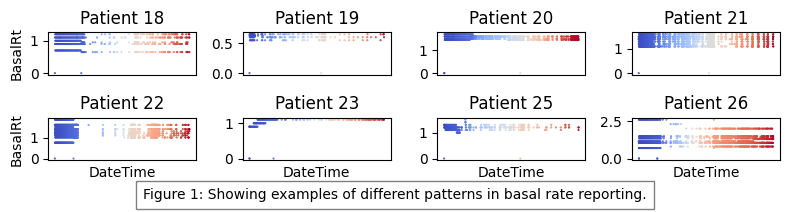

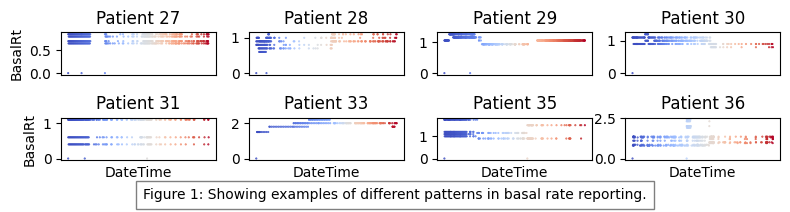

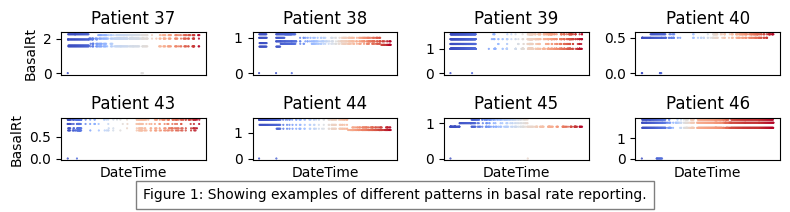

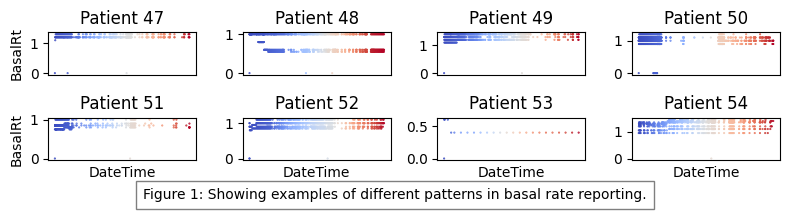

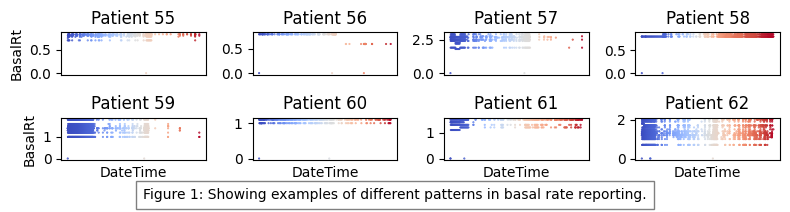

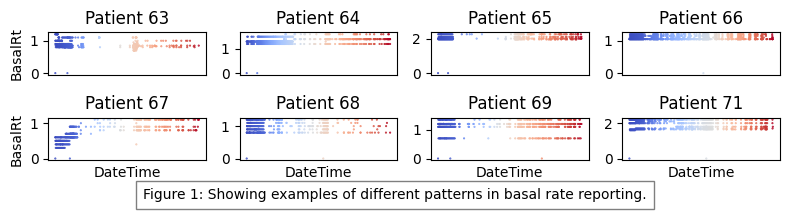

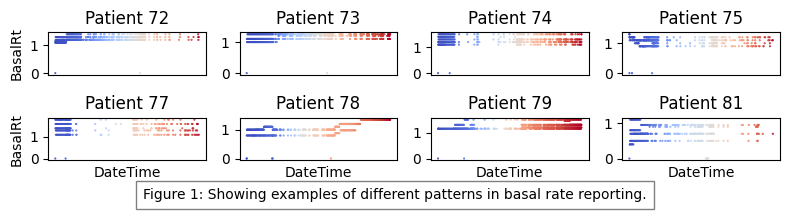

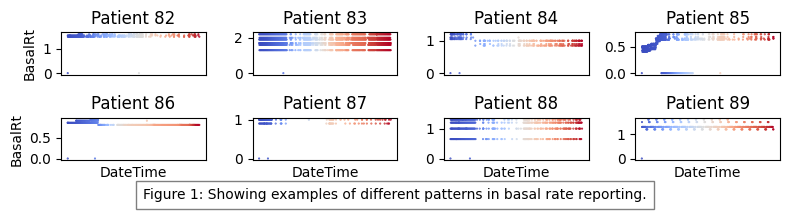

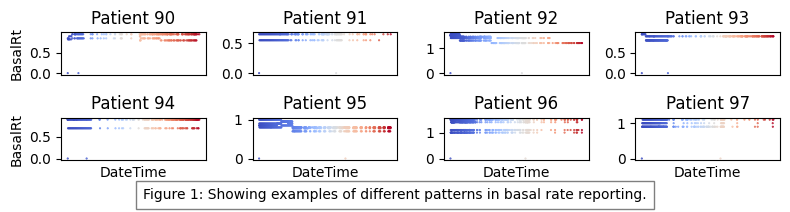

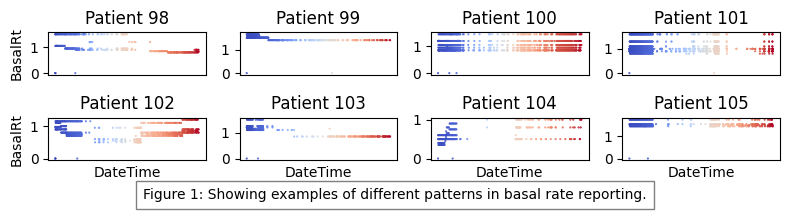

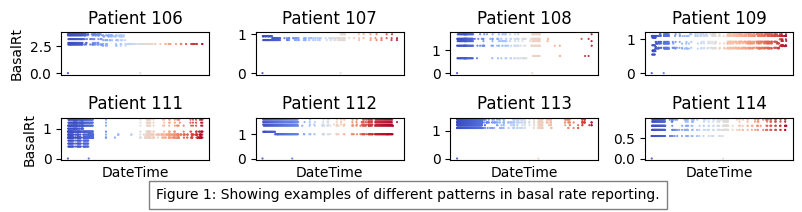

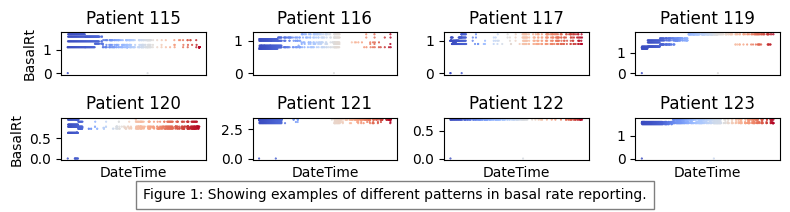

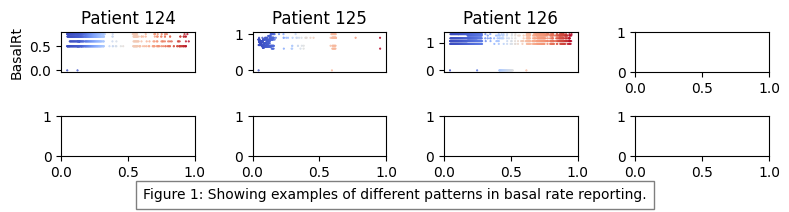

In [8]:
patient_ids = np.sort(np.unique(flair.df_pump.PtID.unique()))
for i in range(0,int(np.ceil(len(patient_ids)/8))):
    ids = patient_ids[i*8:(i+1)*8]
    fig, axs = plt.subplots(2,4, figsize=(8, 2)); axs = axs.flatten()
    for i, patient_id in enumerate(ids):
        subFrame = flair.df_pump.loc[flair.df_pump.PtID == patient_id]#.dropna(subset=['BasalRt'])
        axs[i].scatter(subFrame['DateTime'], subFrame['BasalRt'], c=range(len(subFrame)), cmap='coolwarm', marker='.',s=1)
        axs[i].set_title(f'Patient {patient_id}')
        #hide x ticks
        axs[i].set_xticks([])
        if i>=4:
            axs[i].set_xlabel('DateTime')
        if i%4==0:
            axs[i].set_ylabel('BasalRt')

    plt.tight_layout()
    plt.figtext(0.5, -0.02, "Figure 1: Showing examples of different patterns in basal rate reporting.", ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    plt.show()


From visual inspection we see that 32 out of the 115 users **(28%)** show a pattern of lower basal frequency in one part of the study. 

**Extreme cases are:** 1,14,63,65,77,87,124,125

**Strong cases are:** 2,3,12,17,18,25,26,28,39,40,43,50,56,57,59,64,68,69,72,74,75,79, 81,126

1. First row: basal rates regularly change start to end
2. Second Row: basal rates changebut in the middle they are not reported or very infrequently
3. Third Row: Basal rates are first reported regularly, then stop or very rarely
4. Forth Row: Basal rates remain constant 

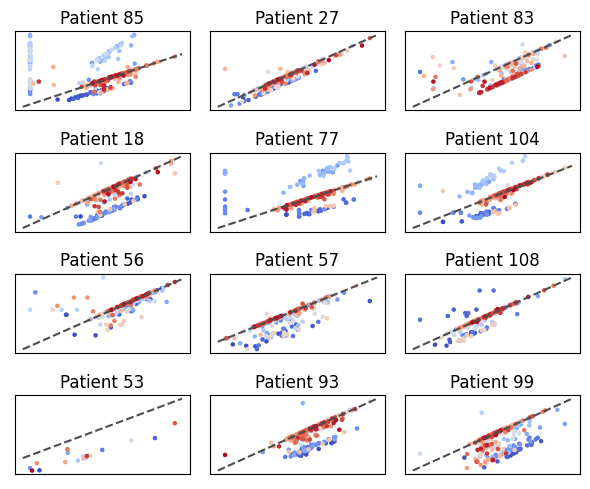

In [9]:
#scatter plot tdd_calcualted vs tdd_extracted for this patient
patient_ids = [85,27,83,   18,77,104,  56,57,108,  53,93,99]

fig, axs = plt.subplots(4, 3, figsize=(6, 5)); axs = axs.flatten()
for i, patient_id in enumerate(patient_ids):
    TDDs.loc[str(patient_id)].plot.scatter(x='tdd_reported', y='bolus', c=range(len(TDDs.loc[str(patient_id)])), cmap='coolwarm', marker='.', ax=axs[i])
    axs[i].set_title(f'Patient {patient_id}')
    #unity line
    axs[i].plot(axs[i].get_xlim(), axs[i].get_xlim(), ls="--", c=".3")
    #hide x and y ticks
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].set_xlabel(''); axs[i].set_ylabel('')
plt.tight_layout()
plt.show()

In order to understand what is really happening, we need to look at the study protocol and individuals. Let's start with patient 99 for which we know the bolus alsmost exactly matches TDD:


## Investigate Patient 99 more closely

We now investigate patient 99:

bolus                           43.97
basal                       32.990611
tdd_calculated              76.960611
DateTime          2019-02-28 23:59:59
tdd_reported                   43.125
datetime          2019-02-28 23:59:59
Name: 2019-02-28, dtype: object

Text(0.5, 0.98, 'Patient 99')

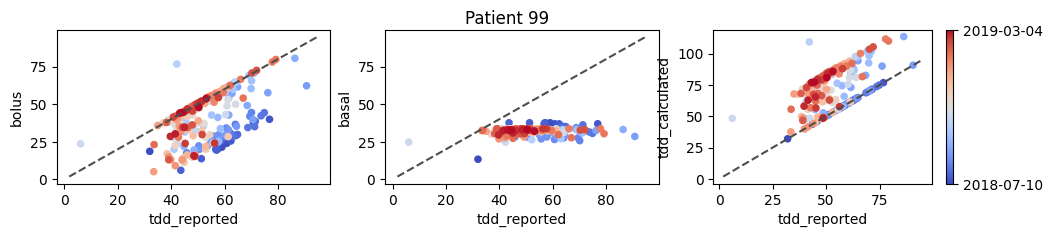

In [10]:
f, AX = plt.subplots(1,3, figsize=(12, 2))
display(TDDs.loc['99'].iloc[-5])
#scatter plot tdd_calcualted vs tdd_extracted for this patient
TDDs.loc['99'].sort_index().plot.scatter(x='tdd_reported', y='bolus', c=range(len(TDDs.loc['99'])), cmap='coolwarm', marker='o', ax = AX[0])
TDDs.loc['99'].sort_index().plot.scatter(x='tdd_reported', y='basal', c=range(len(TDDs.loc['99'])), cmap='coolwarm', marker='o', ax = AX[1])
TDDs.loc['99'].sort_index().plot.scatter(x='tdd_reported', y='tdd_calculated', c=range(len(TDDs.loc['99'])), cmap='coolwarm', marker='o', ax = AX[2])

#add unity line with limits to the limits of the current axis
AX[0].plot(AX[0].get_xlim(), AX[0].get_xlim(), ls="--", c=".3")
AX[1].plot(AX[1].get_xlim(), AX[1].get_xlim(), ls="--", c=".3")
AX[2].plot(AX[2].get_xlim(), AX[2].get_xlim(), ls="--", c=".3")
#add a heatmap of the colors that we used for scatter plotting
# Add a heatmap of the colors that we used for scatter plotting
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=0, vmax=len(TDDs.loc['99'])))
cbar = plt.colorbar(sm)
cbar.set_ticks([0, len(TDDs.loc['99'])])  # Set ticks to start and end
cbar.set_ticklabels([TDDs.loc['99'].index.min(), TDDs.loc['99'].index.max()])  # Set tick labels to start and end dates
#title patient id
f.suptitle('Patient 99')

In [11]:
from datetime import datetime
#patient 99 date 2019-02-28
date = datetime(2019,2,28).date()
patient = 99
print(f"TDD for patient {patient} is {TDDs.tdd_reported.loc[str(patient),date].values[0]}")

#get the raw data subframe for that day
df = flair.df_pump.loc[(flair.df_pump.PtID==patient) & (flair.df_pump.DateTime.dt.date == date)]
print(f"Bolus delivered sum is {df.BolusDeliv.sum()}")

subBasals = basal.loc[(basal.patient_id == str(patient)) & (basal.datetime.dt.date == date)]
print(f"There are {len(df.dropna(subset=['BasalRt']))} basal events in the original dataframe but {len(subBasals)} in the extracted basal dataframe")
display(subBasals)

TDD for patient 99 is 43.125
Bolus delivered sum is 43.97
There are 0 basal events in the original dataframe but 2 in the extracted basal dataframe


,patient_id,datetime,basal_rate
2520575,99,2019-02-28 05:49:32,0.0
2520574,99,2019-02-28 06:15:39,1.4


As we can see, for this day there are no basals! So we must have an error in the basal forward filling. 

The original dataframe has no data but the extracted does. We see that the index 2520574 is in fact a suspend event. We probably used this to forward propagate the basal rate of the previous day. We see that no basal rates were reported after the 27th and we forward filled this for the suspends. This might have been wrong. It looks like this is the end of the dataframe.

In [12]:
# show row 2520574
flair.df_pump.loc[2520574]

PtID                                     99
DataDtTm               2/28/2019 6:15:39 AM
NewDeviceDtTm                           NaN
BasalRt                                 NaN
BasalRtUnKnown                        False
TempBasalAmt                            NaN
TempBasalType                           NaN
TempBasalDur                            NaN
BolusType                               NaN
BolusSelected                           NaN
BolusDeliv                              NaN
ExtendBolusDuration                     NaN
PrimeVolumeDeliv                        NaN
Suspend                      NORMAL_PUMPING
Rewind                                  NaN
BolusSource                             NaN
TDD                                     NaN
AutoModeFeat                            NaN
AutoModeStatus                          NaN
AutoBolusFeat                           NaN
PLGMFeat                                NaN
DateTime                2019-02-28 06:15:39
Name: 2520574, dtype: object

## Bolus Duplicates

As a surprise finding, we see that the CLOSED_LOOP+MICRO_BOLUS and CL_MICRO_BOLUS are duplicated for this patient.  Let's how often we have duplicates.

In [13]:
#let's look at the first row (patient 14, date 2019-09-17)
tmp = flair.df_pump.loc[(flair.df_pump.PtID==14) & (flair.df_pump.DateTime.dt.date == datetime(2019,9,17).date())]
tmp.dropna(subset=['BolusDeliv','BasalRt'],how='all').sort_values('DateTime').head(10)[['PtID','DateTime','BolusDeliv','BolusSource','BasalRt']]

,PtID,DateTime,BolusDeliv,BolusSource,BasalRt
2422868,14,2019-09-17 00:00:00,NaN,NaN,1.55
2443131,14,2019-09-17 00:04:52,0.180,CLOSED_LOOP_MICRO_BOLUS,NaN
156388,14,2019-09-17 00:04:52,0.175,CL_MICRO_BOLUS,NaN
2443130,14,2019-09-17 00:09:44,0.050,CLOSED_LOOP_MICRO_BOLUS,NaN
156387,14,2019-09-17 00:09:44,0.050,CL_MICRO_BOLUS,NaN
156386,14,2019-09-17 00:14:42,0.050,CL_MICRO_BOLUS,NaN
2443129,14,2019-09-17 00:14:42,0.050,CLOSED_LOOP_MICRO_BOLUS,NaN
156385,14,2019-09-17 00:19:52,0.275,CL_MICRO_BOLUS,NaN
2443128,14,2019-09-17 00:19:52,0.280,CLOSED_LOOP_MICRO_BOLUS,NaN
156384,14,2019-09-17 00:24:50,0.275,CL_MICRO_BOLUS,NaN


In [14]:
temp = flair.df_pump.dropna(subset=['BolusDeliv'])
duplicates = temp.duplicated(subset=['PtID', 'DateTime', 'BolusDeliv'], keep='first')
temp[duplicates]['BolusSource'].value_counts()

CL_MICRO_BOLUS                              36692
CLOSED_LOOP_MICRO_BOLUS                     36287
CL_BG_CORRECTION_N_FOOD_BOLUS                1658
CLOSED_LOOP_BG_CORRECTION_AND_FOOD_BOLUS     1646
CLOSED_LOOP_FOOD_BOLUS                        693
CL_FOOD_BOLUS                                 638
CLOSED_LOOP_BG_CORRECTION                     174
CL_BG_CORRECTION                              166
BOLUS_WIZARD                                   67
MANUAL                                          7
Name: BolusSource, dtype: int64

Let's continue checking how often we have duplicates for micro boluses

In [15]:
temp = flair.df_pump.dropna(subset=['BolusDeliv'])
temp = temp[temp.BolusSource.isin(['CL_MICRO_BOLUS', 'CLOSED_LOOP_MICRO_BOLUS'])]

duplicates = temp.duplicated(subset=['PtID','DateTime', 'BolusDeliv'], keep='first')
print(f"Number of duplicated micro boluses rows {duplicates.sum()} in percent these are {100*duplicates.sum()/len(temp):.1f}% of all micro boluses")

#show the first 4 duplicated rows
duplicates = temp.duplicated(subset=['PtID', 'DateTime', 'BolusDeliv'], keep=False)#this makes sure we keep all duplicates for displaying
temp[duplicates].dropna(subset=['BolusDeliv'],how='all').sort_values('DateTime').head(2).dropna(axis=1).drop(['DataDtTm'], axis=1)

Number of duplicated micro boluses rows 72979 in percent these are 2.3% of all micro boluses


,PtID,BasalRtUnKnown,BolusType,BolusSelected,BolusDeliv,BolusSource,DateTime
1223509,20,False,Normal,0.1,0.1,CLOSED_LOOP_MICRO_BOLUS,2018-08-23 18:15:44
101098,20,False,Normal,0.1,0.1,CL_MICRO_BOLUS,2018-08-23 18:15:44


In [16]:
temp = flair.df_pump.dropna(subset=['BolusDeliv'])
duplicates = temp.duplicated(subset=['PtID', 'DateTime', 'BolusDeliv'], keep='first') #keep only first duplciate row
print(f"Overall, we have {duplicates.sum()} duplicated bolus rows which makes {duplicates.sum()/len(temp)*100:.2f}% of all boluses")
#show the first 4 duplicated rows
duplicates = temp.duplicated(subset=['PtID', 'DateTime', 'BolusDeliv'], keep=False)#this makes sure we keep all duplicates for displaying
temp[duplicates].dropna(subset=['BolusDeliv'],how='all').sort_values('DateTime').head(2).dropna(axis=1,how='all').drop(['DataDtTm','BasalRtUnKnown'],axis=1)

Overall, we have 78088 duplicated bolus rows which makes 2.20% of all boluses


,PtID,BolusType,BolusSelected,BolusDeliv,ExtendBolusDuration,BolusSource,DateTime
104176,20,Dual (square part),2.3,2.3,0:30:00,NaN,2018-07-11 19:18:00
1223945,20,Dual (square part),2.3,2.3,0:30:00,BOLUS_WIZARD,2018-07-11 19:18:00


Let's see how many duplicates we have per bolus source 

### TDD after removing duplicated Boluses

In [17]:
bolus_wo_dups = bolus[~bolus.duplicated(subset=['patient_id','datetime', 'bolus'], keep='first')]

#calcualte bolus tdd
date = bolus_wo_dups.datetime.dt.date
date.name='date'
tdd_boluses_wo_dups = bolus_wo_dups.groupby(['patient_id',date]).agg({'bolus':'sum'})
TDDs = TDDs.join(tdd_boluses_wo_dups, rsuffix='_wo_dups')

Text(0.5, -0.02, 'Figure 2:TDDs calculated from boluses after removing duplicates improves TDD (one cluster disappears).')

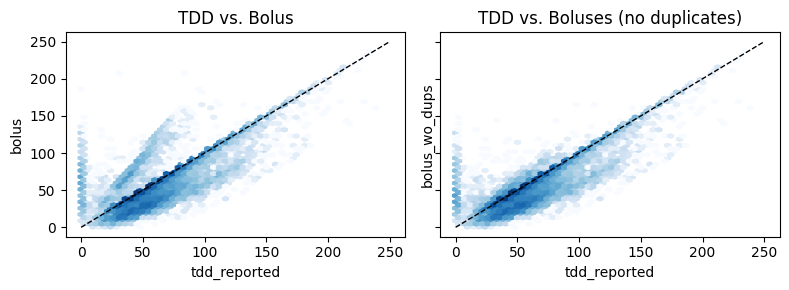

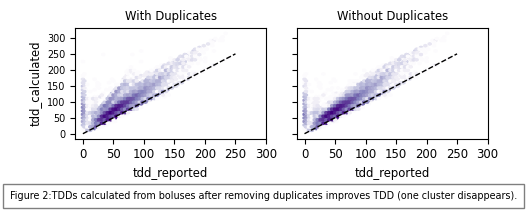

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)

# Hexbin plot for TDD vs. Bolus with logarithmic color scale
hb1 = axs[0].hexbin(TDDs.tdd_reported, TDDs.bolus, gridsize=50, cmap='Blues', mincnt=1, norm=colors.LogNorm())
axs[0].set_xlabel('tdd_reported')
axs[0].set_ylabel('bolus')
axs[0].set_title('TDD vs. Bolus')
#cb1 = fig.colorbar(hb1, ax=axs[0])
#cb1.set_label('log(count)')
axs[0].plot([0, 250], [0, 250], '--',color='black',linewidth=1)

# Hexbin plot for TDD vs. Boluses (no duplicates) with logarithmic color scale
hb2 = axs[1].hexbin(TDDs.tdd_reported, TDDs.bolus_wo_dups, gridsize=50, cmap='Blues', mincnt=1, norm=colors.LogNorm())
axs[1].set_xlabel('tdd_reported')
axs[1].set_ylabel('bolus_wo_dups')
axs[1].set_title('TDD vs. Boluses (no duplicates)')
axs[1].plot([0, 250], [0, 250], '--',color='black',linewidth=1)
plt.tight_layout()

# Repeat for the second set of plots with logarithmic color scale
fig, axs = plt.subplots(1, 2, figsize=(5, 2), sharex=True, sharey=True)

# Hexbin plot for TDD vs TDD with logarithmic color scale
hb3 = axs[0].hexbin(TDDs.tdd_reported, TDDs.bolus+TDDs.basal, gridsize=50, cmap='Purples', mincnt=1, norm=colors.LogNorm())
axs[0].set_xlabel('tdd_reported',fontsize='small')
axs[0].set_ylabel('tdd_calculated',fontsize='small')
axs[0].set_title('With Duplicates',fontsize='small')
axs[0].plot([0, 250], [0, 250], '--',color='black',linewidth=1)
axs[0].set_xticks(range(0, 301, 50))
axs[0].tick_params(axis='x', labelsize='small')
axs[0].set_yticks(range(0, 301, 50))
axs[0].tick_params(axis='y', labelsize='x-small')

# Hexbin plot for TDD vs. TDD (no duplicates) with logarithmic color scale
hb4 = axs[1].hexbin(TDDs.tdd_reported, TDDs.bolus_wo_dups+TDDs.basal, gridsize=50, cmap='Purples', mincnt=1, norm=colors.LogNorm())
axs[1].set_xlabel('tdd_reported',fontsize='small')
#axs[1].set_ylabel('tdd_calculated_wo_dups')
axs[1].set_title('Without Duplicates',fontsize='small')
axs[1].plot([0, 250], [0, 250], '--',color='black',linewidth=1)
axs[1].set_xticks(range(0, 301, 50))
axs[1].tick_params(axis='x', labelsize='small')
plt.tight_layout()
plt.figtext(0.5, -0.02, "Figure 2:TDDs calculated from boluses after removing duplicates improves TDD (one cluster disappears).", ha="center", fontsize='x-small', bbox={"facecolor":"white", "alpha":0.5, "pad":5})

## Zero TDDs and TDD duplicates

### Zero TDDs
Let's start investigating a day where reported TDD is zero. 

In [19]:
(TDDs.tdd_reported == 0).sum()

360

Visualize some patients

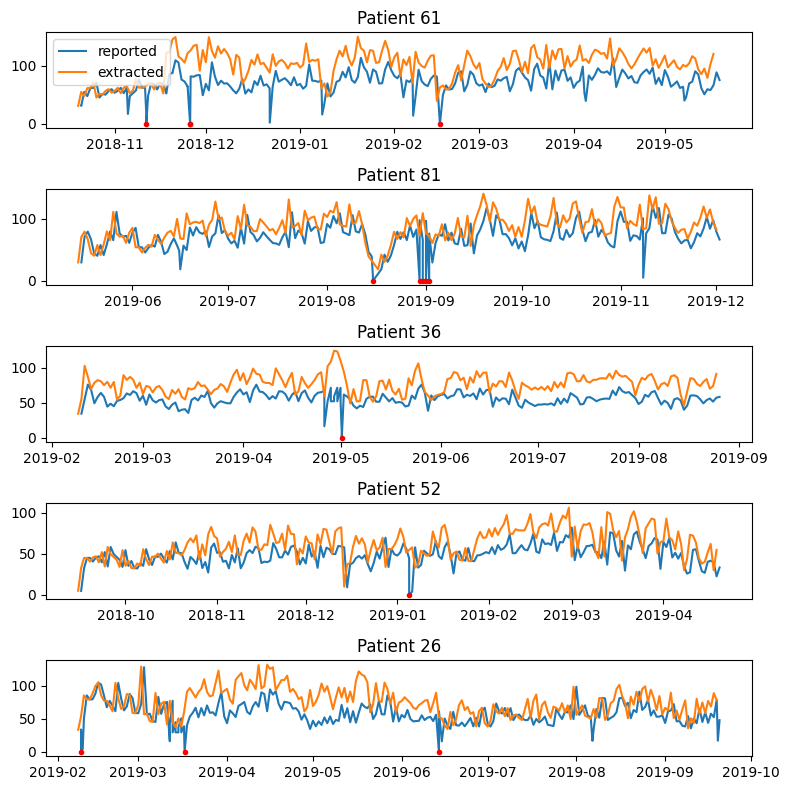

In [20]:
#get affected patients
tdd_zero = TDDs.loc[TDDs.tdd_reported == 0]
patients_with_tdd_zero = tdd_zero.index.get_level_values('patient_id').unique().astype(int)

# Select all patients with TDD zero
fig, axs = plt.subplots(5, 1, figsize=(8, 8))

for i, patient in enumerate(np.random.choice(patients_with_tdd_zero, 5)):
    temp = flair.df_pump.loc[(flair.df_pump.PtID == patient)].dropna(subset=['TDD'])
    bZero = temp.TDD == 0
    axs[i].plot(temp.DateTime, temp.TDD, label='reported')
    axs[i].plot(temp.DateTime[bZero], temp.TDD[bZero], 'r.')
    
    temp2 = TDDs.loc[str(patient)].reset_index()
    axs[i].plot(temp2.date, temp2.bolus_wo_dups + temp2.basal, label='extracted')
    axs[i].set_title(f"Patient {patient}")

axs[0].legend()
plt.tight_layout()
plt.show()


### Multiple TDDs
Let's check if tdds are reported several times

In [21]:
print(f" There are {(TDDs.groupby(['patient_id','date']).tdd_reported.count()>1).sum()} days with multiple reported tdds")
print("This is how many tdds are reported per day")
display(TDDs.groupby(['patient_id','date']).tdd_reported.count().value_counts())

 There are 1035 days with multiple reported tdds
This is how many tdds are reported per day


1    23047
2      925
3       91
4       13
5        6
Name: tdd_reported, dtype: int64

Let's look at patient 104 on 2019-06-10 for which several TDDs are reported. We see that 
1. TDDs are unequal
2. zero TDD in between
2. last TDD is not the largest

In [22]:
x=flair.df_pump.loc[(flair.df_pump.PtID == 104) & (flair.df_pump.DateTime.dt.date == datetime(2019,6,10).date())].dropna(subset=['TDD'])
display(x.dropna(axis=1, how='all'))

,PtID,DataDtTm,BasalRtUnKnown,TDD,DateTime
972850,104,6/10/2019 6:37:00 PM,False,12.975,2019-06-10 18:37:00
4303707,104,6/10/2019 6:37:00 PM,False,12.970,2019-06-10 18:37:00
972841,104,6/10/2019 6:38:30 PM,False,0.000,2019-06-10 18:38:30
4303676,104,6/10/2019 11:59:59 PM,False,10.520,2019-06-10 23:59:59
972816,104,6/10/2019 11:59:59 PM,False,10.525,2019-06-10 23:59:59


### Describe TDD duplicates

In [23]:
print(f"There are {(TDDs.tdd_reported==0).sum()} zero TDDs in the dataset")
print(f"There are {TDDs.datetime.apply(lambda x: x.hour <23).sum()} TDDs reported before 23:00")
print(f"There are {TDDs.groupby(['patient_id','date']).size().gt(1).sum()} days with multiple TDDs reported")

There are 360 zero TDDs in the dataset
There are 277 TDDs reported before 23:00
There are 1035 days with multiple TDDs reported


The question is now, how do we deal with this: 
1. Taking the maximum reported TDD (this will not always yield the latest reported)
2. Taking the last reported TDD (This will not always report the maximum value, sometimes even 0)
3. Dropping zero TDDs (This will for some days drop tdd altogether)

### TDD: Max, Latest, Sum

In [24]:
#TDDs = TDDs.drop(columns=['tdd_reported_max','tdd_reported_latest','tdd_reported_sum'])

#### latest

In [31]:
#example keeping the latest TDD
latest  = TDDs.groupby(['patient_id','date']).apply(lambda x: x.iloc[x.DateTime.argmax()])
print(f"For the days with multiple TDDs, after keeping only the last TDD:...")
print(f"there are {(latest.tdd_reported==0).sum()} zero TDDs in the dataset")
print(f"there are {latest.datetime.apply(lambda x: x.hour <23).sum()} TDDs before 23:00")
print(f"there are {latest.groupby(['patient_id','date']).size().gt(1).sum()} patients with multiple TDDs per day")

#join for later use
TDDs = TDDs.join(latest['tdd_reported'],rsuffix='_latest')

temp = (TDDs.groupby(['patient_id','date']).agg({'tdd_reported_latest': 'first'})==0).tdd_reported_latest.eq(0).sum()
print(f"There are {temp} days with multiple TDDs per day where the last TDD is zero");


For the days with multiple TDDs, after keeping only the last TDD:...
there are 141 zero TDDs in the dataset
there are 12 TDDs before 23:00
there are 0 patients with multiple TDDs per day
There are 23941 days with multiple TDDs per day where the last TDD is zero


#### maximum

In [32]:
max_tdd  = TDDs.groupby(['patient_id','date']).apply(lambda x: x.iloc[x.tdd_reported.argmax()])
print(f"After keeping only the max TDD")
print(f"there are {(max_tdd.tdd_reported==0).sum()} zero TDDs in the dataset")
print(f"there are {max_tdd.datetime.apply(lambda x: x.hour <23).sum()} TDDs before 23:00")
print(f"there are {max_tdd.groupby(['patient_id','date']).size().gt(1).sum()} patients with multiple TDDs per day")

#join to TDDs
TDDs = TDDs.join(max_tdd['tdd_reported'],rsuffix='_max')

After keeping only the max TDD
there are 2 zero TDDs in the dataset
there are 68 TDDs before 23:00
there are 0 patients with multiple TDDs per day


#### sum

In [33]:
summed_tdd = TDDs.groupby(['patient_id','date']).agg({'tdd_reported':'sum'})
print(f"After keeping only the sum of TDD")
print(f"there are {(summed_tdd.tdd_reported==0).sum()} zero TDDs in the dataset")
print(f"there are {summed_tdd.groupby(['patient_id','date']).size().gt(1).sum()} patients with multiple TDDs per day")

#join to TDDs
TDDs = TDDs.join(summed_tdd,rsuffix='_sum')

After keeping only the sum of TDD
there are 2 zero TDDs in the dataset
there are 0 patients with multiple TDDs per day


Compare in plot

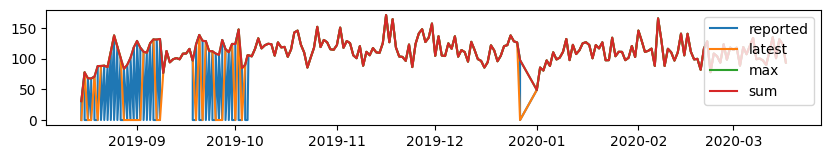

In [34]:
plt.figure(figsize=(10, 1.5))
plt.plot(TDDs.loc['14'].datetime, TDDs.loc['14'].tdd_reported, label='reported')
plt.plot(TDDs.loc['14'].datetime, TDDs.loc['14'].tdd_reported_latest, label='latest')
plt.plot(TDDs.loc['14'].datetime, TDDs.loc['14'].tdd_reported_max, label='max')
plt.plot(TDDs.loc['14'].datetime, TDDs.loc['14'].tdd_reported_sum, label='sum')
plt.legend()

Text(0.5, -0.02, 'Figure 1: Compensating for days with multiple reported TDDs using max or sum.')

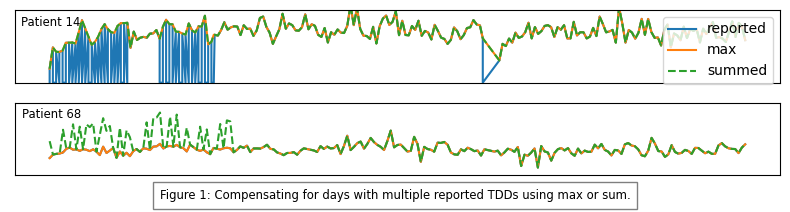

In [35]:
#get affected patients
#duplicated_tdds = TDDs.groupby(['patient_id','date']).filter(lambda x: len(x) > 1)
#patients_with_duplicated_tdds = duplicated_tdds.index.get_level_values('patient_id').unique().astype(int)
#patient_ids = np.random.choice(patients_with_duplicated_tdds, 8)
patient_ids = [14,68] # for reproducibility

fig, axs = plt.subplots(2, 1, figsize=(8, 2))
for i, patient in enumerate(patient_ids):
    axs[i].plot(TDDs.loc[str(patient)].datetime, TDDs.loc[str(patient)].tdd_reported, label='reported')
    axs[i].plot(TDDs.loc[str(patient)].datetime, TDDs.loc[str(patient)].tdd_reported_max, label='max')
    axs[i].plot(TDDs.loc[str(patient)].datetime, TDDs.loc[str(patient)].tdd_reported_sum, '--',label='summed')
    #axs[i].set_title(f"Patient {patient}",fontsize='small')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].tick_params(axis='y', labelsize='small')
    axs[i].tick_params(axis='x', labelsize='small')
    axs[i].text(axs[i].get_xlim()[0]+2,125,f"Patient {patient}", fontsize='small')
    axs[i].set_ylim(0,160)
axs[0].legend()
plt.tight_layout()
plt.figtext(0.5, -0.02, "Figure 1: Compensating for days with multiple reported TDDs using max or sum.", ha="center", fontsize='small', bbox={"facecolor":"white", "alpha":0.5, "pad":5})

Here, it appears that taking the summed value overestimates TDD (patient 2). Let's look at how the sum of TDDs would compare against the calculated TDD.

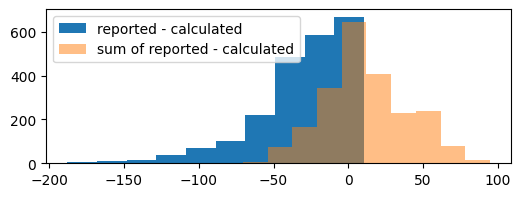

In [36]:
plt.figure(figsize=(6,2))
duplicated_tdds = TDDs.groupby(['patient_id','date']).filter(lambda x: len(x) > 1).reset_index()
plt.hist(duplicated_tdds.tdd_reported-(duplicated_tdds.basal+duplicated_tdds.bolus_wo_dups), label='reported - calculated')
plt.hist(duplicated_tdds.tdd_reported_sum-(duplicated_tdds.basal+duplicated_tdds.bolus_wo_dups),alpha=0.5,label='sum of reported - calculated')
plt.legend()

This shows the general pattern which we have seen before, calculated TDDs over-estimate reported TDD. This is jnot a sign that we should use the sum, just because it is more centered around the reported.

Now, let's see how the scatter plot would change

Text(0.5, -0.02, 'Figure 2: Multiple reported TDDs and their daily sum or max value')

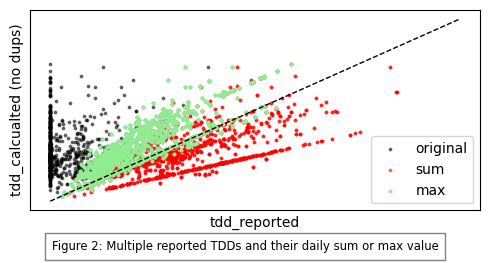

In [37]:
# Hexbin plot for TDD vs. Boluses (no duplicates) with logarithmic color scale
ax = plt.figure(figsize=(5,2.5)).gca()


#hb2 = ax.hexbin(TDDs.tdd_reported,  TDDs.basal+TDDs.bolus_wo_dups, gridsize=50, cmap='Blues', mincnt=1, norm=colors.LogNorm())
ax.scatter(duplicated_tdds.tdd_reported,   duplicated_tdds.basal+duplicated_tdds.bolus_wo_dups, color='black', marker='o', s =3, alpha=0.5, label='original')
ax.scatter(duplicated_tdds.tdd_reported_sum,   duplicated_tdds.basal+duplicated_tdds.bolus_wo_dups, color='red', marker='o', s =3, alpha=0.5, label='sum')
ax.scatter(duplicated_tdds.tdd_reported_max,duplicated_tdds.basal+duplicated_tdds.bolus_wo_dups, color='lightgreen', marker='o', s =3, label='max')
ax.plot([0, 250], [0, 250], '--',color='black',linewidth=1)
ax.legend()

ax.set_xlabel('tdd_reported')
ax.set_ylabel('tdd_calcualted (no dups)')
ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(axis='y', labelsize='small')
ax.tick_params(axis='x', labelsize='small')    
plt.tight_layout()
plt.figtext(0.5, -0.02, "Figure 2: Multiple reported TDDs and their daily sum or max value", ha="center", fontsize='small', bbox={"facecolor":"white", "alpha":0.5, "pad":5})

Taking the sum causes a lot of under-estimates of calcualted TDD. This is agains the general trend which indicates (as we have seen before) that taking the sum is probably wrong. Taking the maximum value however moves the clusters closer to another and does not change the general trend. **For now, taking the maximum reported basal rate is the best bet.**

Text(0.5, -0.02, 'Figure 3: Calculated vs. Reported TDDs as is (left) and taking the daily maximum value (right)')

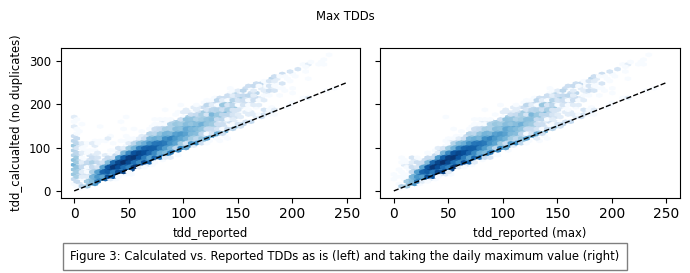

In [38]:
# Hexbin plot for TDD vs. Boluses (no duplicates) with logarithmic color scale
#get the first row, this makes sure we don't draw values for duplicated reported TDDs several times
temp = TDDs.groupby(['patient_id','date']).agg('first') 

f,AX = plt.subplots(1,2,figsize=(7,2.5),sharey=True)

AX[0].hexbin(temp.tdd_reported, temp.bolus_wo_dups+temp.basal, gridsize=50, cmap='Blues', mincnt=1, norm=colors.LogNorm())
AX[0].plot([0, 250], [0, 250], '--',color='black',linewidth=1)
AX[0].set_xlabel('tdd_reported',fontsize='small')

AX[1].hexbin(temp.tdd_reported_max, temp.bolus_wo_dups+temp.basal, gridsize=50, cmap='Blues', mincnt=1, norm=colors.LogNorm())
AX[1].plot([0, 250], [0, 250], '--',color='black',linewidth=1)
AX[1].set_xlabel('tdd_reported (max)',fontsize='small')
AX[0].set_ylabel('tdd_calcualted (no duplicates)',fontsize='small')
AX[0].tick_params(axis='y', labelsize='small')

plt.suptitle('Max TDDs',fontsize='small')
plt.tight_layout()
plt.figtext(0.5, -0.02, "Figure 3: Calculated vs. Reported TDDs as is (left) and taking the daily maximum value (right)", ha="center", fontsize='small', bbox={"facecolor":"white", "alpha":0.5, "pad":5})

Taking the sum removes the zero TDDs but it also now, many calcualted tdds are too low.

## Algorithm Impact on reported TDDs?

first we merge with patient roster to get the control group (remember this is cross over study)

In [39]:
df_patient = pd.read_csv(os.path.join(study_dataset_path,'Data Tables', 'PtRoster.txt'),sep='|')
merged = flair.df_pump.merge(df_patient[['PtID','TrtGroup']],on='PtID')
display(merged.TrtGroup.value_counts())

#get the time and day since study start
merged['time_sinde_study_start'] = merged.groupby(['PtID']).DateTime.apply(lambda x: x-x.min())
merged['days_since_study_start'] = merged['time_sinde_study_start'].transform(lambda x: x.days)

670G    2567427
AHCL    2531833
Name: TrtGroup, dtype: int64

In [40]:
#reported TDDs by day
temp = merged.groupby(['TrtGroup','PtID','days_since_study_start']).agg(reported_tdd_count = ('TDD', 'count'))
display(temp.groupby(['TrtGroup']).agg({'reported_tdd_count':'sum'}))

#number of days with more than one TDD
temp = merged.groupby(['TrtGroup','PtID','days_since_study_start']).agg(reported_tdd_count = ('TDD', 'count'))
display(temp.groupby(['TrtGroup']).agg({'reported_tdd_count':lambda x: x.gt(1).sum()}))

,reported_tdd_count
TrtGroup,
670G,12462
AHCL,12819


,reported_tdd_count
TrtGroup,
670G,337
AHCL,690


Interestingly, AHCL group has twice as many days with more than one reported TDD

In [41]:
#zero TDDS
merged.groupby(['TrtGroup']).agg({'TDD': lambda x: (x==0).sum()})

,TDD
TrtGroup,
670G,75
AHCL,322


When patients start on AHCL, then we see many more zero TDDs being reported. This is surprising given that all patients use both algorithms.

check if the auto_boluses differ between treatment groups 

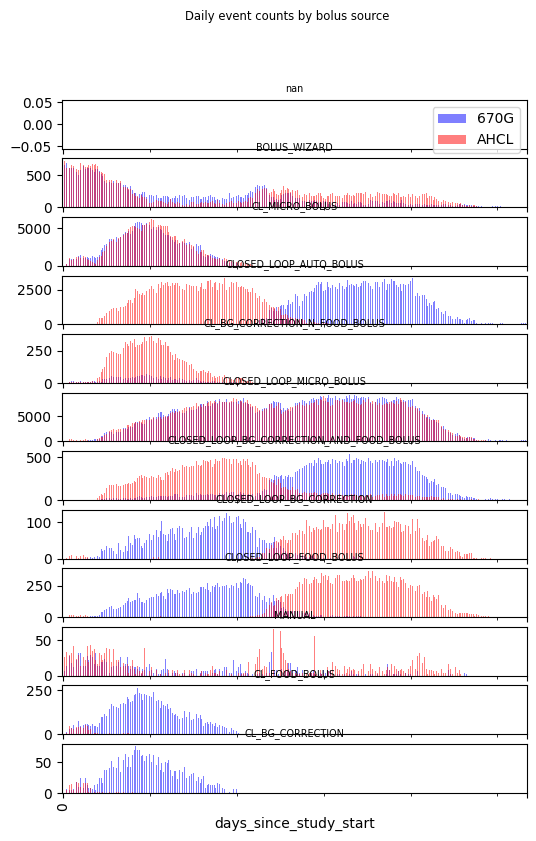

In [42]:

#draw bolus source types
fig, axs = plt.subplots(len(merged.BolusSource.unique()), 1, figsize=(6, 9),sharex=True, sharey=False)
for i, bolus_source in enumerate(merged.BolusSource.unique()):
    ax = axs[i]
    temp = merged.groupby(['TrtGroup', 'days_since_study_start']).agg(micro_bolus_count=('BolusSource', lambda x: (x == bolus_source).sum())).reset_index(level=1)
    temp.loc['670G'].reset_index().plot.bar(x='days_since_study_start', y='micro_bolus_count', ax=ax, label='670G', color='blue', alpha=0.5)
    temp.loc['AHCL'].reset_index().plot.bar(x='days_since_study_start', y='micro_bolus_count', ax=ax, color='red', label='AHCL', alpha=0.5)
    ax.set_title(bolus_source,fontsize='x-small')
    ax.set_xticks([temp.days_since_study_start.min(), temp.days_since_study_start.max()])
    if i == 0:
        ax.legend()
    else:
        ax.get_legend().remove()
plt.suptitle('Daily event counts by bolus source',fontsize='small')
plt.show()

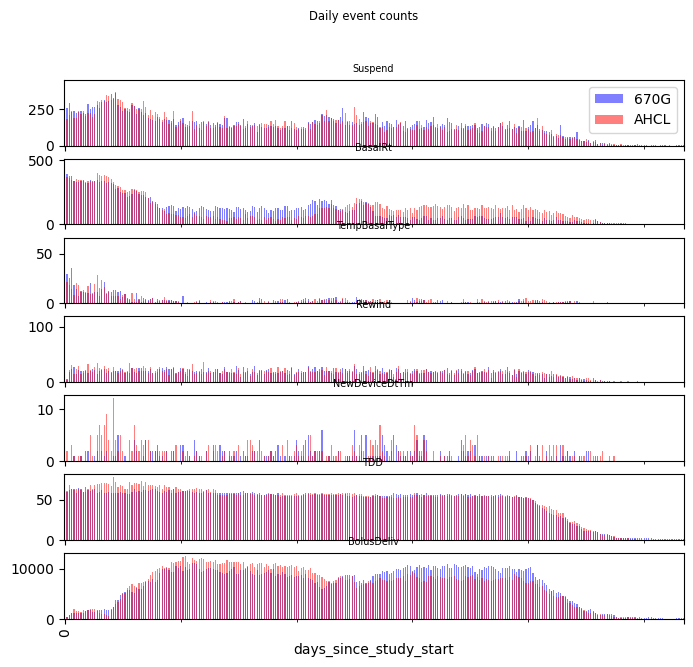

In [43]:
#draw bolus source types
events = ['Suspend','BasalRt','TempBasalType','Rewind','NewDeviceDtTm','TDD','BolusDeliv']
fig, axs = plt.subplots(len(events), 1, figsize=(8, 1*len(events)),sharex=True, sharey=False)
for i, column in enumerate(events):
    ax = axs[i]
    temp = merged.groupby(['TrtGroup', 'days_since_study_start']).agg({column:'count'}).reset_index(level=1)
    temp.loc['670G'].reset_index().plot.bar(x='days_since_study_start', y=column, ax=ax, label='670G', color='blue', alpha=0.5)
    temp.loc['AHCL'].reset_index().plot.bar(x='days_since_study_start', y=column, ax=ax, color='red', label='AHCL', alpha=0.5)
    ax.set_title(column, fontsize='x-small')
    ax.set_xticks([temp.days_since_study_start.min(), temp.days_since_study_start.max()])
    if i == 0:
        ax.legend()
    else:
        ax.get_legend().remove()
plt.suptitle('Daily event counts',fontsize='small')
plt.show()

Findings
1) Basl Rates are less often in the AHCL algorithm 
2) What we see is that the Auto Boluses source is not reported in the 670G treatment arm. (Remeber, this is crossover). 
3) CL_MICRO_BOLUSES are only reported at the beginning (maybe label change to CLOSED_LOOP_MICRO_BOLUS?)

## Closed Loop Mode
After talking to a Medtronic Expert, we learned that basal rates are disabled during closed loop mode. 
> when in closed loop, basal rate is shut off and every delivery is a bolus. accidentally counting basal at times closed loop is active could explain some of the difference

This explains why on some days, TDDs matches the sum of boluses. 

These are the relevant columns from the data glossary in the pump file.

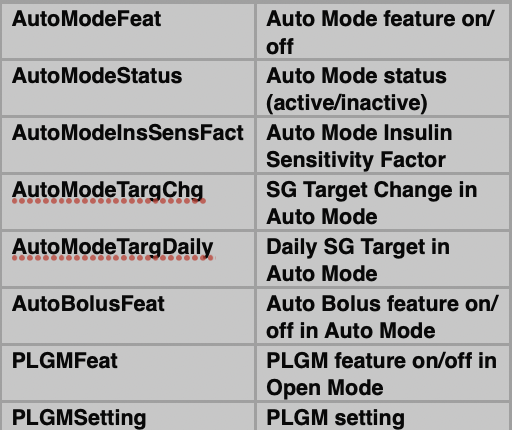

Questions: Are there auto-modes where basal rates are still active?
* The distribution of basal rates since study start suggests that basal rates continue to be reported regardless of the algorithm.
* The data also shows that basal rates are not manipulated (don't jump up and down like we would expect if a PID would be applied to basal).
* Question: When are temp basals applied, only manual?


The study procotol and device description does not mention how basal rates are modulated.

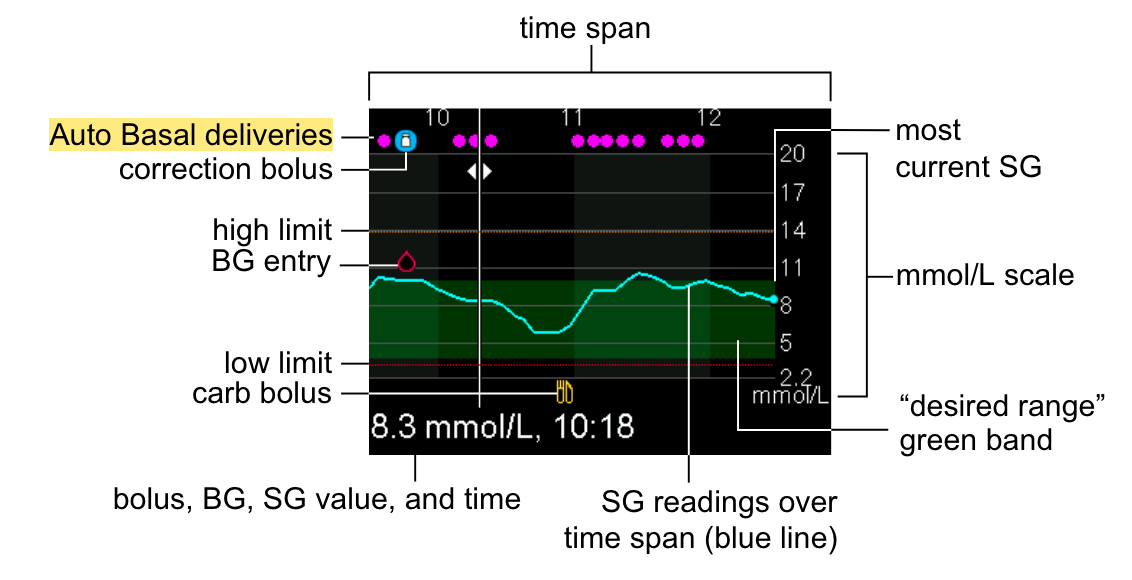
> The numerous small magenta dots along the top represent the automatically delivered basal insulin (Auto Basal or Safe Basal) delivered by SmartGuard Auto Mode.

Medtronic separates between correction boluses and basal adjustments. 


In [44]:
#get the unique values of the AutoModeFeat, AutoModeStatus, AutoBolusFeat, PLGMFeat, PLGMSetting columns
for column in ['AutoModeFeat', 'AutoModeStatus', 'AutoBolusFeat', 'PLGMFeat']:
    display(flair.df_pump[column].value_counts())


True     1472
False    1254
Name: AutoModeFeat, dtype: int64

True     10923
False    10670
Name: AutoModeStatus, dtype: int64

True     238
False     24
Name: AutoBolusFeat, dtype: int64

True     389
False    282
Name: PLGMFeat, dtype: int64

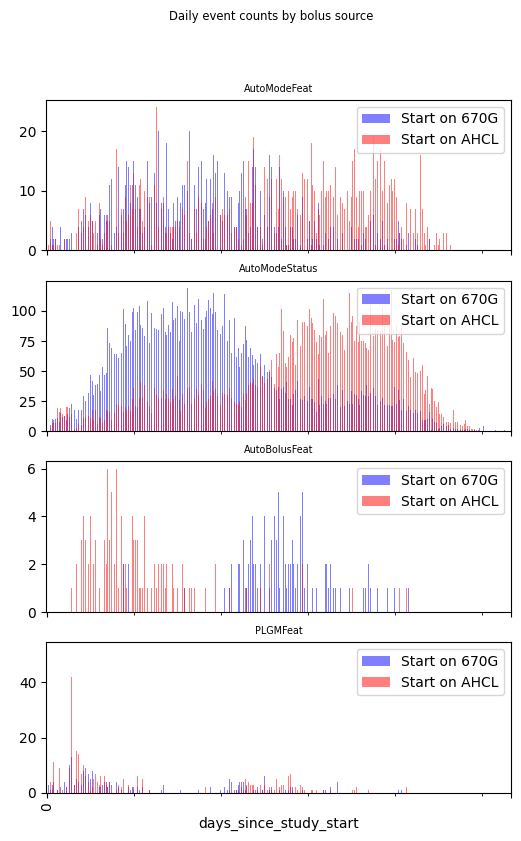

In [70]:

#draw bolus source types
columns = ['AutoModeFeat', 'AutoModeStatus', 'AutoBolusFeat', 'PLGMFeat']
fig, axs = plt.subplots(len(columns), 1, figsize=(6, 9),sharex=True, sharey=False)
for i, column in enumerate(columns):
    ax = axs[i]
    out_name = f'{column}_count'
    temp = merged.groupby(['TrtGroup', 'days_since_study_start']).agg(**{out_name: (column, 'count')}).reset_index(level=1)
    temp.loc['670G'].reset_index().plot.bar(x='days_since_study_start', y=out_name, ax=ax, label='Start on 670G', color='blue', alpha=0.5)
    temp.loc['AHCL'].reset_index().plot.bar(x='days_since_study_start', y=out_name, ax=ax, color='red', label='Start on AHCL', alpha=0.5)
    ax.set_title(column,fontsize='x-small')
    ax.set_xticks([temp.days_since_study_start.min(), temp.days_since_study_start.max()])
    ax.legend()
    if i > 0:
        #ax.get_legend().remove()
        pass
plt.suptitle('Daily event counts by bolus source',fontsize='small')
plt.show()

<AxesSubplot:ylabel='Frequency'>

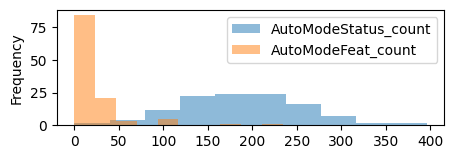

In [97]:
#show all AutoModeStatus rows for patient 104
plt.figure(figsize=(5,1.5))
ax= merged.groupby('PtID').agg(AutoModeStatus_count = ('AutoModeStatus','count')).plot.hist(ax=plt.gca(),alpha=0.5)
merged.groupby('PtID').agg(AutoModeFeat_count = ('AutoModeFeat','count')).plot.hist(ax=ax,alpha=0.5)

The number of auto mode status changes varies significanly by user. For some users, the feature seems to be turned on/off quite often (orange outliers.)

In [154]:
import pandas as pd
from collections import namedtuple

def find_periods(df, value_col, time_col, start_trigger, stop_trigger):
    # Define the named tuple
    Period = namedtuple('Period', ['index_start', 'index_end', 'time_start', 'time_end', 'duration', 'value_start', 'value_end'])
    
    # Remove rows with NaN values in the time column
    df = df.dropna(subset=[time_col])
    
    # Sort the DataFrame by time
    df = df.sort_values(by=time_col).reset_index(drop=True)
    
    # Initialize variables to track periods
    periods = []
    start_index = None
    start_time = None
    
    # Iterate through the DataFrame rows to find periods
    for i, row in df.iterrows():
        if row[value_col] == start_trigger and start_index is None:
            start_index = i
            start_time = row[time_col]
        elif row[value_col] == stop_trigger and start_index is not None:
            end_index = i
            end_time = row[time_col]
            duration = (end_time - start_time).total_seconds() if isinstance(end_time, pd.Timestamp) else end_time - start_time
            periods.append(Period(start_index, end_index, start_time, end_time, duration, start_trigger, stop_trigger))
            start_index = None  # Reset start_index to find the next period
    
    return periods

def filter_by_periods(df, time_col, periods):
    mask = pd.Series([False] * len(df))
    
    for period in periods:
        start_time = period.time_start
        end_time = period.time_end
        mask |= (df[time_col] >= start_time) & (df[time_col] <= end_time)
    
    return df.loc[mask]


# Example usage
temp = pd.DataFrame({
    'AutoModeStatus': ['off', 'on', 'on', 'off', 'off', 'off', 'off', 'on', 'on', 'off'],
    'DateTime': [pd.Timestamp('2023-01-01 00:00:00'), pd.Timestamp('2023-01-01 01:00:00'), pd.Timestamp('2023-01-01 02:00:00'),
                 pd.Timestamp('2023-01-01 03:00:00'), pd.Timestamp('2023-01-01 04:00:00'), pd.Timestamp('2023-01-01 05:00:00'),
                 pd.Timestamp('2023-01-01 06:00:00'), pd.Timestamp('2023-01-01 07:00:00'), pd.Timestamp('2023-01-01 08:00:00'),
                 pd.Timestamp('2023-01-01 09:00:00')]
})
display(temp)
start_trigger = 'on'
stop_trigger = 'off'

periods = find_periods(temp, 'AutoModeStatus', 'DateTime', start_trigger, stop_trigger)
display(periods)
filter_by_periods(temp, 'DateTime', periods)


,AutoModeStatus,DateTime
0,off,2023-01-01 00:00:00
1,on,2023-01-01 01:00:00
2,on,2023-01-01 02:00:00
3,off,2023-01-01 03:00:00
4,off,2023-01-01 04:00:00
5,off,2023-01-01 05:00:00
6,off,2023-01-01 06:00:00
7,on,2023-01-01 07:00:00
8,on,2023-01-01 08:00:00
9,off,2023-01-01 09:00:00


[Period(index_start=1, index_end=3, time_start=Timestamp('2023-01-01 01:00:00'), time_end=Timestamp('2023-01-01 03:00:00'), duration=7200.0, value_start='on', value_end='off'),
 Period(index_start=7, index_end=9, time_start=Timestamp('2023-01-01 07:00:00'), time_end=Timestamp('2023-01-01 09:00:00'), duration=7200.0, value_start='on', value_end='off')]

,AutoModeStatus,DateTime
1,on,2023-01-01 01:00:00
2,on,2023-01-01 02:00:00
3,off,2023-01-01 03:00:00
7,on,2023-01-01 07:00:00
8,on,2023-01-01 08:00:00
9,off,2023-01-01 09:00:00


In [150]:
# Now, we want to check how many micro boluses are reported during on and off periods
# First, we need to extract the on and off periods, which are stored in the AutoModeStatus column
#get the rows where AutoModeStatus is not nan for user 104
temp = merged.loc[merged.PtID == 104].dropna(subset=['AutoModeStatus']).sort_values('DateTime')
display(temp.dropna(axis=1, how='all'))

,PtID,DataDtTm,BasalRtUnKnown,AutoModeStatus,DateTime,TrtGroup,time_sinde_study_start,days_since_study_start
4239530,104,6/16/2019 5:40:12 PM,False,True,2019-06-16 17:40:12,AHCL,27 days 05:09:14,27
4245786,104,7/1/2019 2:17:06 PM,False,False,2019-07-01 14:17:06,AHCL,42 days 01:46:08,42
4245802,104,7/1/2019 4:42:23 PM,False,True,2019-07-01 16:42:23,AHCL,42 days 04:11:25,42
4256523,104,7/30/2019 6:24:41 AM,False,False,2019-07-30 06:24:41,AHCL,70 days 17:53:43,70
4256547,104,7/30/2019 9:40:48 AM,False,True,2019-07-30 09:40:48,AHCL,70 days 21:09:50,70
...,...,...,...,...,...,...,...,...
4289743,104,12/11/2019 6:15:09 AM,False,True,2019-12-11 06:15:09,AHCL,204 days 17:44:11,204
4289957,104,12/12/2019 2:32:00 AM,False,False,2019-12-12 02:32:00,AHCL,205 days 14:01:02,205
4289972,104,12/12/2019 6:57:17 AM,False,True,2019-12-12 06:57:17,AHCL,205 days 18:26:19,205
4290181,104,12/13/2019 4:03:00 AM,False,False,2019-12-13 04:03:00,AHCL,206 days 15:32:02,206


In [149]:
temp = merged.loc[merged.PtID == 104].dropna(subset=['AutoModeStatus']).sort_values('DateTime')
find_periods(temp, 'AutoModeStatus', 'DateTime', True, False)

[Period(index_start=0, index_end=1, time_start=Timestamp('2019-06-16 17:40:12'), time_end=Timestamp('2019-07-01 14:17:06'), duration=1283814.0, value_start=True, value_end=False),
 Period(index_start=2, index_end=3, time_start=Timestamp('2019-07-01 16:42:23'), time_end=Timestamp('2019-07-30 06:24:41'), duration=2468538.0, value_start=True, value_end=False),
 Period(index_start=4, index_end=6, time_start=Timestamp('2019-07-30 09:40:48'), time_end=Timestamp('2019-09-17 13:29:00'), duration=4247292.0, value_start=True, value_end=False),
 Period(index_start=7, index_end=8, time_start=Timestamp('2019-09-17 16:42:22'), time_end=Timestamp('2019-09-17 19:47:00'), duration=11078.0, value_start=True, value_end=False),
 Period(index_start=9, index_end=10, time_start=Timestamp('2019-09-17 23:11:09'), time_end=Timestamp('2019-09-18 03:59:00'), duration=17271.0, value_start=True, value_end=False),
 Period(index_start=11, index_end=12, time_start=Timestamp('2019-09-18 04:22:01'), time_end=Timestamp('

In [147]:
temp

,value,time
0,off,0
1,on,1
2,on,4
3,off,9
4,on,16
5,off,25
6,off,36
7,on,49
8,on,64
9,off,81
